In [2]:
from importLibrary import *
import ClassificationModel as CM

In [3]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
seed = 11
#"C:/Users/testb/Desktop/jupyter/grapevine_leaf/Grapevine_Leaves_Image_Dataset"
all_data = tf.keras.utils.image_dataset_from_directory(
    "./Grapevine_Leaves_Image_Dataset",
    labels='inferred',
    label_mode='categorical',  # etichette one-hot
    image_size=IMG_SIZE,  # ad esempio (224, 224)
    batch_size=None  # nessun batch, ottieni tutte le immagini una per una
)

# Estrai le immagini e le etichette dal dataset
image_list = []
label_list = []

for image, label in all_data:
    image_list.append(image.numpy())  # Converti l'immagine in NumPy array
    label_list.append(label.numpy())  # Converti l'etichetta in NumPy array

# Converti le liste in array NumPy
image_array = np.array(image_list)
label_array = np.array(label_list)

print(f"image_array.shape: {image_array.shape}")
print(f"label_array.shape: {label_array.shape}")

# Primo split: ottieni training (70%) e temp (30%) per test+validation
X_train, X_temp, y_train, y_temp = train_test_split(
    image_array, label_array, test_size=0.3, stratify=label_array, random_state=seed  # 30% per validation+test
)

# Secondo split: dividi temp in validation (10%) e test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.66, stratify=y_temp, random_state=seed  # 2/3 per test, 1/3 per validation
)

# Convertire i dati divisi in tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))#.batch(BATCH_SIZE)
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))#.batch(BATCH_SIZE)

Not_norm = True

Found 500 files belonging to 5 classes.
image_array.shape: (500, 256, 256, 3)
label_array.shape: (500, 5)


350
(256, 256, 3)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)


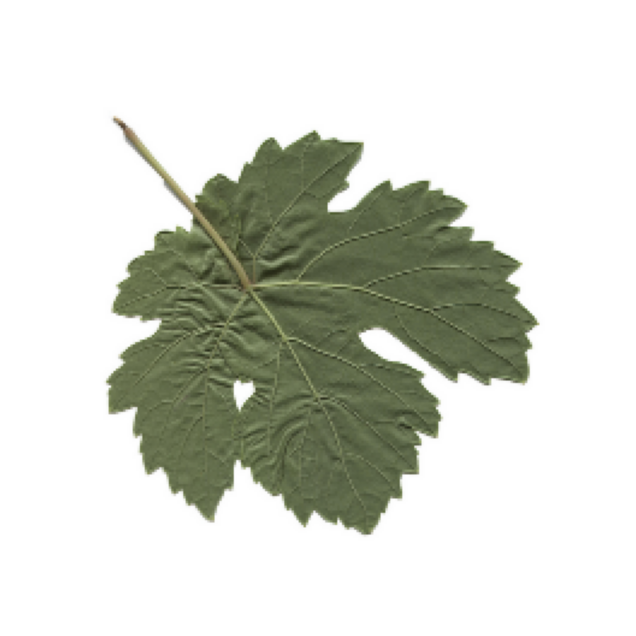

In [7]:
print(train_data.cardinality().numpy()) #num BATCH
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch) # contiene one-hot delle classi
    break

img = image_batch[:,:,:].numpy().astype(np.uint8)
# Converti l'immagine da BGR a RGB (OpenCV usa BGR per default)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crea una figura e un'asse
plt.figure(figsize=(8, 8))  # Puoi regolare le dimensioni della figura
plt.imshow(img)  # Mostra l'immagine
plt.axis('off')  # Disabilita gli assi
plt.show()  # Mostra la figura


In [8]:
# Normalizzazione - NOTA: tf.data.Dataset = img, label
if (Not_norm):
    train_data = train_data.map(lambda x, y: (x / 255.0, y))
    test_data = test_data.map(lambda x, y: (x / 255.0, y))
    Not_norm = False
    
for image_batch, labels_batch in train_data:
    print(np.min(image_batch[100,:,:].numpy()))
    print(labels_batch.numpy())
    break


0.16305059
[0. 1. 0. 0. 0.]


In [9]:
# Define a function for data augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip the image
    # image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change brightness
    # image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Randomly adjust contrast
    return image, label
# Apply the augmentation function
augmented_data = train_data.map(augment_image)

350
(256, 256, 3)


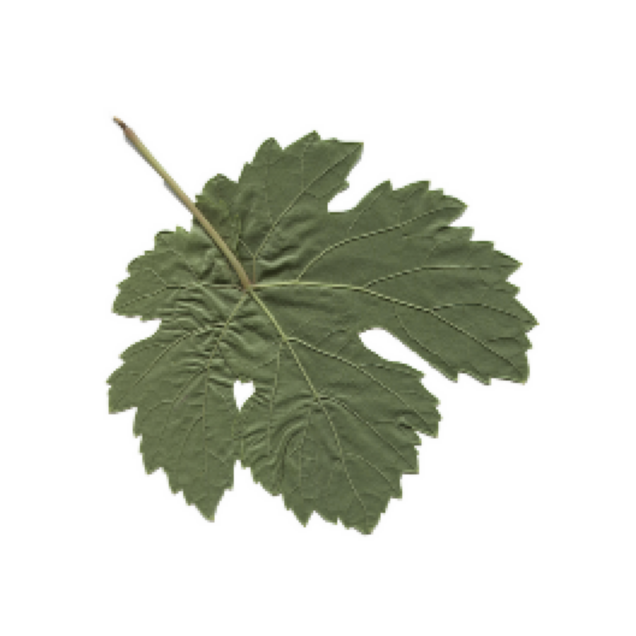

In [16]:
# Converte il dataset in un iteratore numpy
augmented_image, augmented_label = [], []
for images, labels in train_data.as_numpy_iterator():
    augmented_image.append(images)
    augmented_label.append(labels)
    
print(len(augmented_image))
print(augmented_image[0].shape)

img = augmented_image[0]#.astype(np.uint8)
# Converti l'immagine da BGR a RGB (OpenCV usa BGR per default)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crea una figura e un'asse
plt.figure(figsize=(8, 8))  # Puoi regolare le dimensioni della figura
plt.imshow(img)  # Mostra l'immagine
plt.axis('off')  # Disabilita gli assi
plt.show()  # Mostra la figura

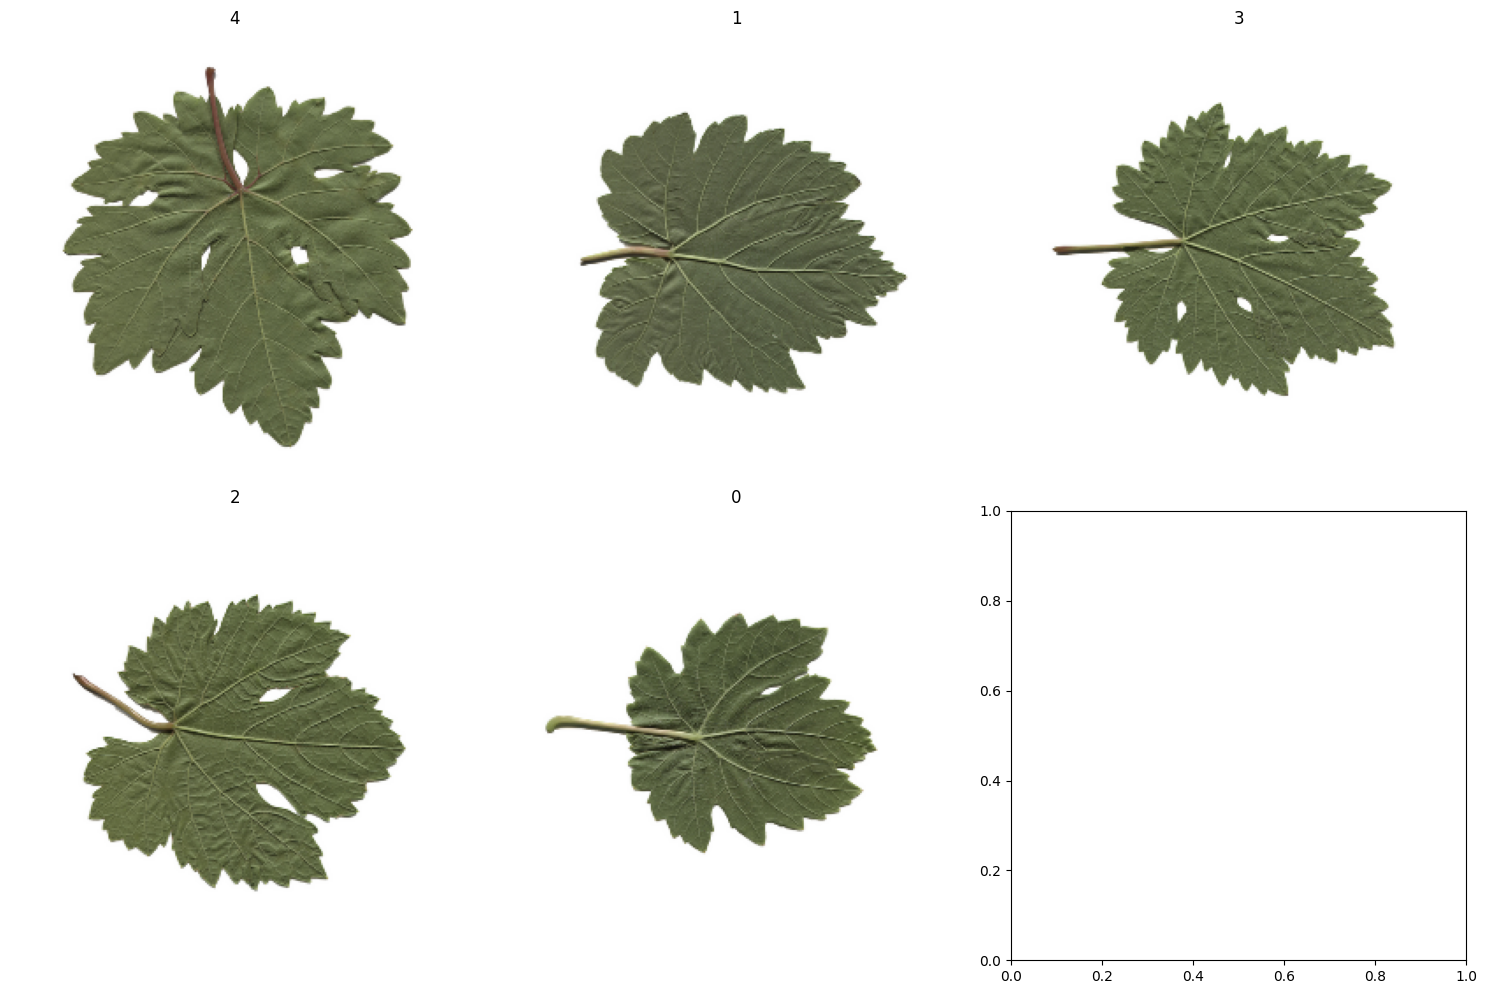

700
[[140. 140. 140. 140. 140.]]


In [18]:
# Combiniamo i due dataset (originale e aumentato)
combined_data = train_data.concatenate(augmented_data)

# Optional: Shuffling e batching del nuovo dataset esteso
combined_data = combined_data.shuffle(buffer_size=1024).batch(BATCH_SIZE)
size =0
num_class_elem = np.zeros((1,5))
IMG = []
LABEL_IMG = []
for i in combined_data:
    img,l = i
    size += img.shape[0]
    num_class_elem += np.sum(l, axis=0) 

    for index, label in enumerate(l):
        idx = np.argmax(label)
        if idx not in LABEL_IMG:
            IMG.append(img[index])
            LABEL_IMG.append(idx)
        if len(LABEL_IMG)==5:
            break
    

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(5):
    ax = axs[i // 3, i % 3]
    ax.imshow(IMG[i])
    ax.axis('off')
    ax.set_title(LABEL_IMG[i])

plt.tight_layout()
plt.show()

print(size)
print(num_class_elem)

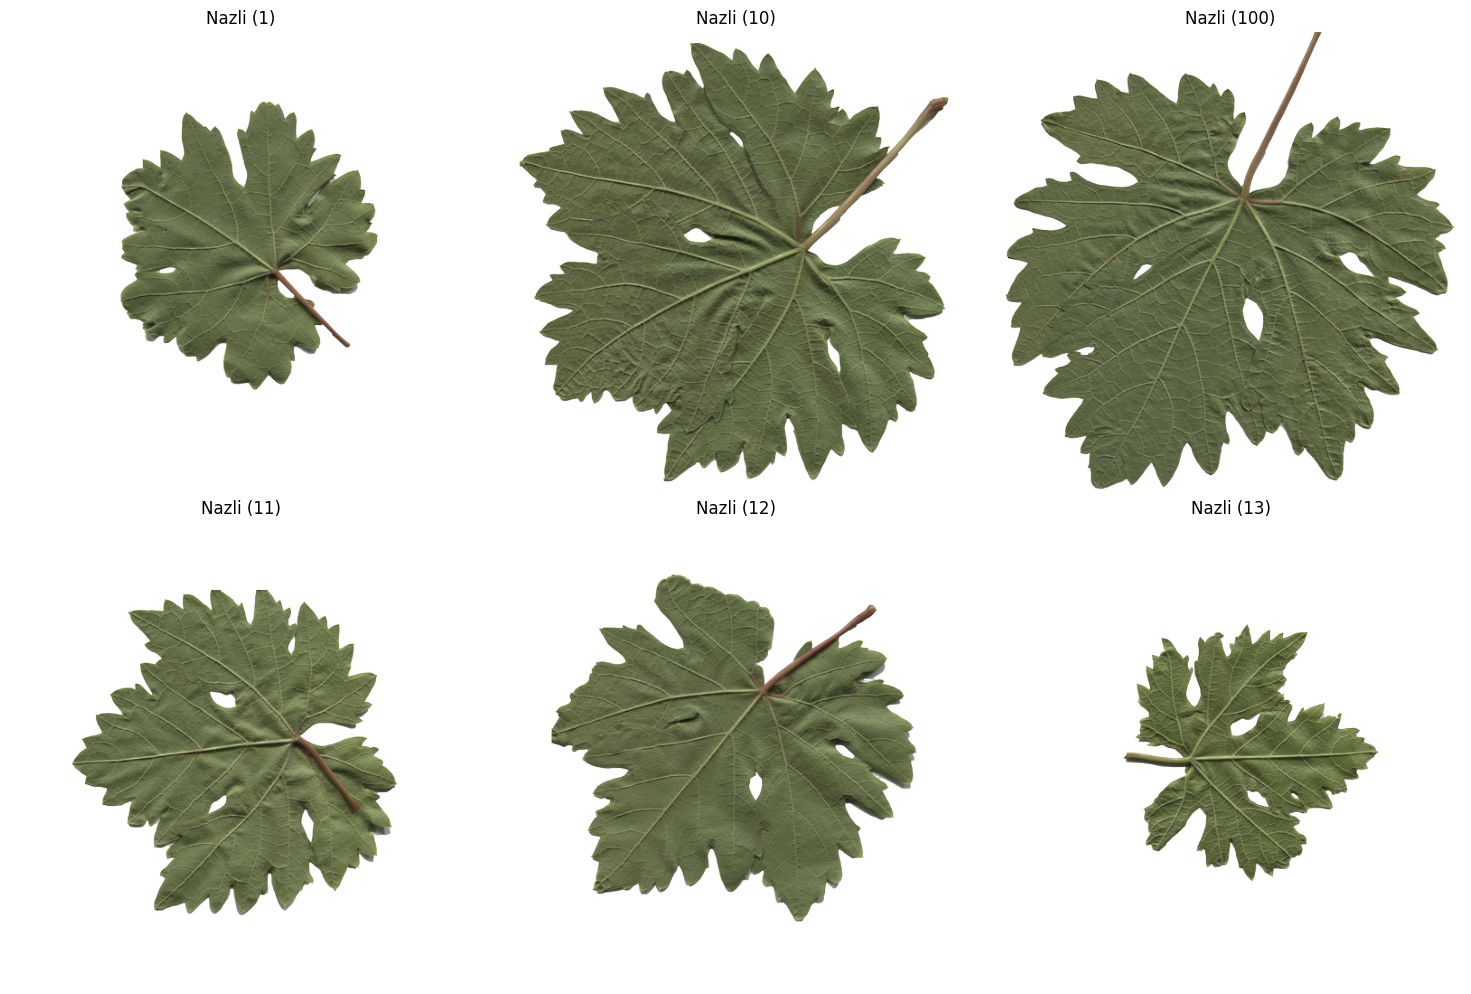

In [19]:
# Path to the directory containing images
path = "./Grapevine_Leaves_Image_Dataset/Nazli"
# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [20]:
num_classes = y_train.shape[1]
model = CM.GenerateResModel(num_classes)
#model = CM.GenerateCNN(num_classes)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,719,173 (90.48 MB)

 Trainable params: 131,461 (513.52 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:

from tensorflow.keras.callbacks import EarlyStopping

# Imposta il callback di Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric da monitorare (ad esempio la perdita sul validation set)
    patience=5,                # Numero di epoche di pazienza (ad esempio, 5)
    restore_best_weights=True  # Ripristina i pesi con le migliori prestazioni sul validation set
)

def TrainModel(model: Model, alpha: float = 0.01, epochs: int = 20):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=alpha), metrics=['categorical_accuracy'])
    #train_d = train_data.batch(BATCH_SIZE)
    
    history = model.fit(
        combined_data,
        epochs=epochs,
        verbose=1,
        validation_data=validation_data,  # Batch di validazione separato con dimensione diversa
        #callbacks=[early_stopping]
    )
    return history

In [ ]:
# name = 'resNet_finetuned_'+str(0)
# model.save('./'+name+'.keras')
H = []
n="resNet_fineTuned_"
for i in range(1,3):
    print("Training ... N° " + str(i))
    if (i!=1):
        model = tf.keras.models.load_model('./'+n+str((i-1)*20)+'.keras')
    history = TrainModel(model, alpha=1e-4, epochs=20)
    H.append(history)
    name = n+str(i*20)
    model.save('./'+name+'.keras')
    

Training ... N° 1
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - categorical_accuracy: 0.2206 - loss: 1.9696 - val_categorical_accuracy: 0.1961 - val_loss: 3.3825
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - categorical_accuracy: 0.1882 - loss: 1.7319 - val_categorical_accuracy: 0.1961 - val_loss: 3.0915
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - categorical_accuracy: 0.2411 - loss: 1.6172 - val_categorical_accuracy: 0.1961 - val_loss: 3.1482
Epoch 4/20
20/22 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - categorical_accuracy: 0.2515 - loss: 1.5946 

In [ ]:
H = []
n="CNN_"
for i in range(1,21):
    if (i!=0):
        M = './'+n+str((i-1)*20)
    print(M)
    print("train")
    M = n+str(i*20)

In [12]:
idx_model = 20
model = tf.keras.models.load_model('./'+n+str(idx_model)+'.keras')

In [12]:
def PlotHistory(history) -> None:
    # Plot training & validation accuracy values
    plt.plot(history.history['categorical_accuracy'], label='train accuracy') #categorical_accuracy
    # plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='train loss')
    # plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
#PlotHistory(history)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
y_pred = model.predict(X_test)
# print(y_pred)
# print(y_test)
max_indices_pred = np.argmax(y_pred, axis=1) #prediction as class number
max_indices_val = np.argmax(y_test, axis=1) #prediction as class number

def PlotMetrics(max_indices_val, max_indices_pred):
    # Create the confusion matrix
    nn_cm = confusion_matrix(max_indices_val, max_indices_pred)
    accuracy = accuracy_score(max_indices_val, max_indices_pred)
    precision = precision_score(max_indices_val, max_indices_pred, average='macro')
    recall = recall_score(max_indices_val, max_indices_pred, average='macro')
    f1 = f1_score(max_indices_val, max_indices_pred, average='macro')

    print(nn_cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

PlotMetrics(max_indices_val, max_indices_pred)

In [15]:
model.save('./my_model.keras')

In [ ]:
loaded_model = tf.keras.models.load_model('./my_model.keras')
h = TrainModel(loaded_model)

In [ ]:
PlotHistory(history)
y_pred = model.predict(X_val)
print(y_pred)
print(y_val)
max_indices_pred = np.argmax(y_pred, axis=1) #prediction as class number
max_indices_val = np.argmax(y_val, axis=1) #prediction as class number
PlotMetrics(max_indices_pred,max_indices_val)